In [1]:
import numpy as np
import seaborn as sb
import pandas as pd
import matplotlib.pyplot as plt
import xgboost as xgb
import pickle

In [2]:
df=pd.read_csv(r"C:\Users\athul\Documents\ML Zoomcamp 2023\Project\Midterm Project\engine_data.csv")

In [3]:
df.head()

,Engine rpm,Lub oil pressure,Fuel pressure,Coolant pressure,lub oil temp,Coolant temp,Engine Condition
0,700,2.493592,11.790927,3.178981,84.144163,81.632187,1
1,876,2.941606,16.193866,2.464504,77.640934,82.445724,0
2,520,2.961746,6.553147,1.064347,77.752266,79.645777,1
3,473,3.707835,19.510172,3.727455,74.129907,71.774629,1
4,619,5.672919,15.738871,2.052251,78.396989,87.000225,0


In [4]:
df.dtypes

Engine rpm            int64
Lub oil pressure    float64
Fuel pressure       float64
Coolant pressure    float64
lub oil temp        float64
Coolant temp        float64
Engine Condition      int64
dtype: object

In [5]:
df.isnull().sum()

Engine rpm          0
Lub oil pressure    0
Fuel pressure       0
Coolant pressure    0
lub oil temp        0
Coolant temp        0
Engine Condition    0
dtype: int64

In [6]:
df['Engine Condition'].value_counts(normalize=True)

Engine Condition
1    0.630509
0    0.369491
Name: proportion, dtype: float64

In [7]:
def dataframe_prep(dfx):
    from sklearn.model_selection import train_test_split
    
    dfx.columns=dfx.columns.str.replace(' ', '_').str.lower()
    col_names=list(df.columns)
    dfx_fulltrain, dfx_test=train_test_split(dfx, test_size=0.2, random_state=1)
    dfx_train, dfx_val=train_test_split(dfx_fulltrain, test_size=0.25, random_state=1)
    
    dfx_fulltrain=dfx_fulltrain.reset_index(drop=True)
    dfx_train=dfx_train.reset_index(drop=True)
    dfx_val=dfx_val.reset_index(drop=True)
    dfx_test=dfx_test.reset_index(drop=True)
    
    return dfx_fulltrain, dfx_train, dfx_val, dfx_test, col_names

In [8]:
df1_fulltrain, df1_train, df1_val, df1_test, ss=dataframe_prep(df)

In [9]:
df1_train.head()

,engine_rpm,lub_oil_pressure,fuel_pressure,coolant_pressure,lub_oil_temp,coolant_temp,engine_condition
0,620,1.529980,8.525785,2.169915,76.296473,80.097347,1
1,397,4.234095,11.441395,1.161447,77.433828,77.671458,1
2,489,3.791840,6.502299,1.619764,77.140308,71.421766,1
3,709,2.552271,3.537746,1.468464,80.427204,84.472509,1
4,856,3.701631,8.080383,3.812844,75.730608,78.594138,1


In [10]:
df1_val.head()

,engine_rpm,lub_oil_pressure,fuel_pressure,coolant_pressure,lub_oil_temp,coolant_temp,engine_condition
0,758,3.781322,5.982021,2.201531,77.653449,73.496234,1
1,607,2.675129,3.393224,1.767393,77.318183,75.633198,1
2,1206,3.895751,5.856937,1.661437,77.021622,74.429779,1
3,646,4.441519,4.366841,1.597622,75.861720,85.733224,1
4,504,3.882175,7.590201,2.348533,75.165939,73.258393,1


In [11]:
df1_test.head()

,engine_rpm,lub_oil_pressure,fuel_pressure,coolant_pressure,lub_oil_temp,coolant_temp,engine_condition
0,1166,2.313936,6.729036,1.412635,77.674721,75.249643,0
1,628,4.645944,5.287920,3.032704,76.417099,82.734634,1
2,485,4.536773,9.158671,1.745094,77.057849,83.061005,1
3,891,2.391241,4.152287,2.503860,77.588072,84.052783,0
4,505,2.241226,7.022183,2.193470,79.352537,83.056734,1


# EDA

In [12]:
#from sklearn.metrics import mutual_info_score

#def mutual_info_churn_score(series):
#    return mutual_info_score(series, df1_train.price)

#mi=round(df1_train[cat_var].apply(mutual_info_churn_score), 2)
#mi.sort_values(ascending=False)

# Data Preparation

In [13]:
ss.remove('engine_condition')

from sklearn.feature_extraction import DictVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import roc_auc_score

def dv_train_val_data(df1t, df1v):
    #Converting Dataframe into Dictionary
    train_dicts=df1t[ss].to_dict(orient='records')
    val_dicts=df1v[ss].to_dict(orient='records')

    #Converting Dictionaries into Vectorized Dictionaries
    dv_small=DictVectorizer(sparse=False)
    dv_small.fit(train_dicts)

    #Preparing Training Data
    X_train= dv_small.transform(train_dicts)
    y_train=df1t.engine_condition.values

    #Preparing Validation Data
    X_val= dv_small.transform(val_dicts)
    y_val=df1v.engine_condition.values
    
    return X_train, y_train, X_val, y_val

In [14]:
X_tr, y_tr, X_v, y_v = dv_train_val_data(df1_train, df1_val)

# Logistic Regression Model

In [15]:
#Logistic regression
lr=LogisticRegression(solver='liblinear', C=10, max_iter=1000, random_state=42)
lr.fit(X_tr, y_tr)
y_pred_lr=lr.predict_proba(X_v)[:, 1]
roc_auc_score(y_v, y_pred_lr)


0.695360612069364

# Decision tree

<Axes: xlabel='None-max_depth', ylabel='min_samples_leaf'>

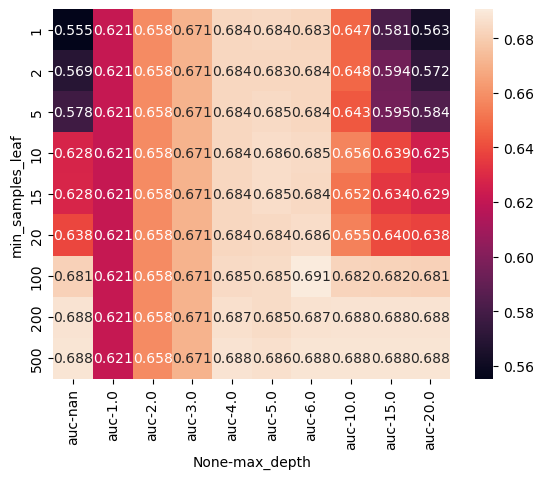

In [16]:
#Decision tree
scores=[]
for d in [1,2,3,4,5,6,10,15,20, None]:
    for s in [1,2,5,10,15,20,100,200,500]:
        dt=DecisionTreeClassifier(max_depth=d, min_samples_leaf=s)
        dt.fit(X_tr, y_tr)

        y_pred_dt=dt.predict_proba(X_v)[:, 1]
        auc=roc_auc_score(y_v, y_pred_dt)

        scores.append((d, s, auc))

colms=['max_depth', 'min_samples_leaf', 'auc']

dt_df_scores=pd.DataFrame(scores, columns=colms)

df_scrs_pvt=dt_df_scores.pivot(index=['min_samples_leaf'], columns=['max_depth'], values=['auc'])
sb.heatmap(df_scrs_pvt, annot=True, fmt='.3f')

In [17]:
dt_max_d=6
dt_msl=100

# Random Forest

In [18]:
#Random Forest
from sklearn.ensemble import RandomForestClassifier

rf=RandomForestClassifier(n_estimators=10, random_state=1)
rf.fit(X_tr, y_tr)
y_pred_rf=rf.predict_proba(X_v)[:, 1]
roc_auc_score(y_v, y_pred_rf)

0.6468181321152668

In [19]:
rf_scores=[]

for d in [5, 10, 15]:
    for n in range (10, 201, 10):
        rf=RandomForestClassifier(n_estimators=n, max_depth=d, random_state=1, n_jobs=-1)

        rf.fit(X_tr, y_tr)
        y_pred_rf=rf.predict_proba(X_v)[:, 1]
        auc_scr=roc_auc_score(y_v, y_pred_rf)
        rf_scores.append((d, s, n, auc_scr))

df_rf_scores=pd.DataFrame(rf_scores, columns=['max_depth','min_samples_leaf','n_estimators', 'auc'])

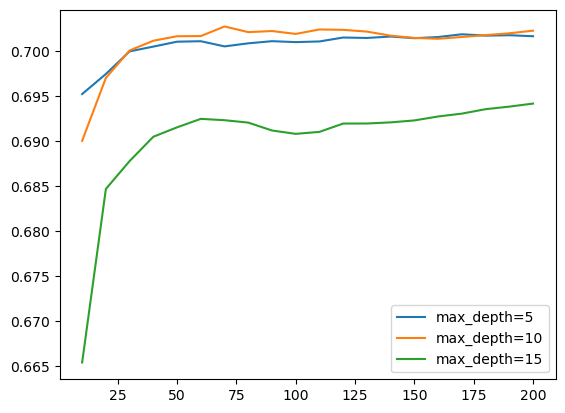

In [20]:
for d in [5, 10, 15]:
    df_rf_subset=df_rf_scores[df_rf_scores.max_depth==d]
    plt.plot(df_rf_subset.n_estimators, df_rf_subset.auc, label='max_depth=%d' %d)

plt.legend()

In [21]:
max_d=10

In [22]:
rf_scores=[]

for s in [1,2,5,10,15,20,100,200,500]:
    for n in range (10, 201, 10):
        rf=RandomForestClassifier(n_estimators=n, max_depth=max_d, min_samples_leaf=s, random_state=1, n_jobs=-1)

        rf.fit(X_tr, y_tr)
        y_pred_rf=rf.predict_proba(X_v)[:, 1]
        auc_scr=roc_auc_score(y_v, y_pred_rf)
        rf_scores.append((d, s, n, auc_scr))

df_rf_scores=pd.DataFrame(rf_scores, columns=['max_depth','min_samples_leaf','n_estimators', 'auc'])

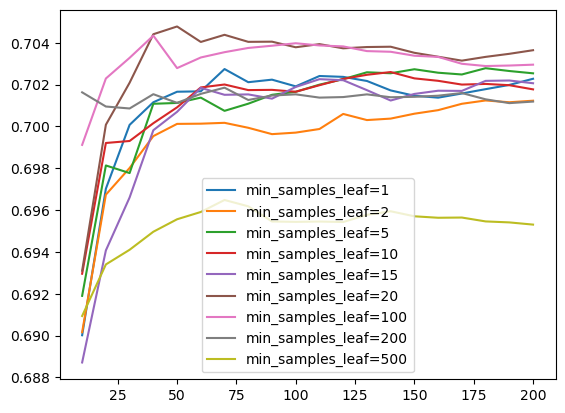

In [23]:
for s in [1,2,5,10,15,20,100,200,500]:
    df_rf_subset=df_rf_scores[df_rf_scores.min_samples_leaf==s]
    plt.plot(df_rf_subset.n_estimators, df_rf_subset.auc, label='min_samples_leaf=%d' %s)

plt.legend()

Best Random Forest Model

In [24]:
max_sl=20
max_n=50

In [25]:
#Best Random Forest Model
rf=RandomForestClassifier(n_estimators=max_n, max_depth=max_d, min_samples_leaf=max_sl, random_state=1, n_jobs=-1)
rf.fit(X_tr, y_tr)
y_pred_rf=rf.predict_proba(X_v)[:, 1]
roc_auc_score(y_v, y_pred_rf)

0.7047782127836102

In [26]:
df_rf_scores.head()

,max_depth,min_samples_leaf,n_estimators,auc
0,15,1,10,0.690018
1,15,1,20,0.697022
2,15,1,30,0.700075
3,15,1,40,0.701156
4,15,1,50,0.701658


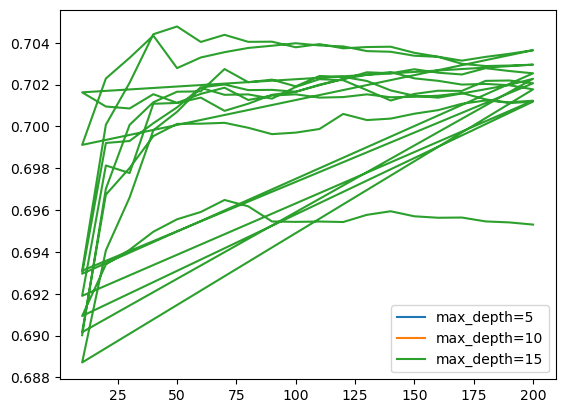

In [27]:
for d in [5, 10, 15]:
    df_rf_subset=df_rf_scores[df_rf_scores.max_depth==d]
    plt.plot(df_rf_subset.n_estimators, df_rf_subset.auc, label='max_depth=%d' %d)

plt.legend()

# XGBoost

In [28]:
#XGBoost

from sklearn.feature_extraction import DictVectorizer

dv=DictVectorizer(sparse=False)
train_dicts=df1_train[ss].to_dict(orient='records')
val_dicts=df1_val[ss].to_dict(orient='records')
dv.fit(train_dicts)
#fn=dv.get_feature_names_out().tolist()

#Preparing Training Data
X_train= dv.transform(train_dicts)
y_train=df1_train.engine_condition.values

#Preparing Validation Data
X_val= dv.transform(val_dicts)
y_val=df1_val.engine_condition.values

dtrain=xgb.DMatrix(X_train, label=y_train, feature_names=ss)
dval=xgb.DMatrix(X_val, label=y_val, feature_names=ss)

In [29]:
%%capture output

xgb_params={'eta':0.3, 
            'max_depth':6, 
            'min_child_weight':1, 
            'objective':'binary:logistic',
            'eval_metric':'auc',
            'nthread': 8, 
            'seed': 1, 
            'verbosity': 1}
watchlist=[(dtrain, 'train'), (dval, 'val')]

xgb_model=xgb.train(xgb_params, dtrain, num_boost_round=400, verbose_eval=10, evals=watchlist)

In [30]:
xgb_model

Converting XGBoost output into a dataset

In [31]:
def parse_xgb_output(output):
    results = []

    for line in output.stdout.strip().split('\n'):
        it_line, train_line, val_line = line.split('\t')

        it = int(it_line.strip('[]'))
        train = float(train_line.split(':')[1])
        val = float(val_line.split(':')[1])

        results.append((it, train, val))
    
    columns = ['num_iter', 'train_auc', 'val_auc']
    df_results = pd.DataFrame(results, columns=columns)
    return df_results

df_score = parse_xgb_output(output)

In [32]:
df_score.head()

,num_iter,train_auc,val_auc
0,0,0.72375,0.68482
1,10,0.78001,0.69834
2,20,0.81414,0.69232
3,30,0.84071,0.68923
4,40,0.86014,0.68549


In [33]:
y_pred=xgb_model.predict(dval)
roc_auc_score(y_val, y_pred)

0.6465595616674313

Plotting the model to check overfitting and Performance

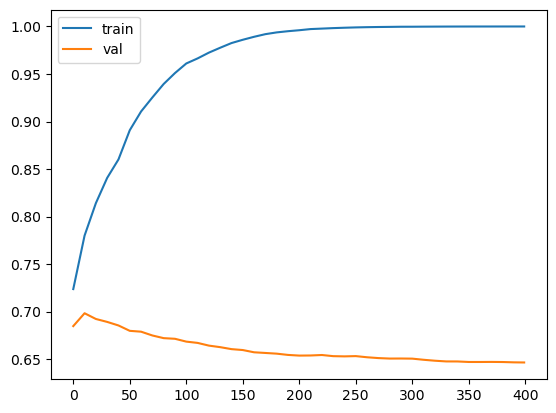

In [34]:
plt.plot(df_score.num_iter, df_score.train_auc, label='train')
plt.plot(df_score.num_iter, df_score.val_auc, label='val')
plt.legend()

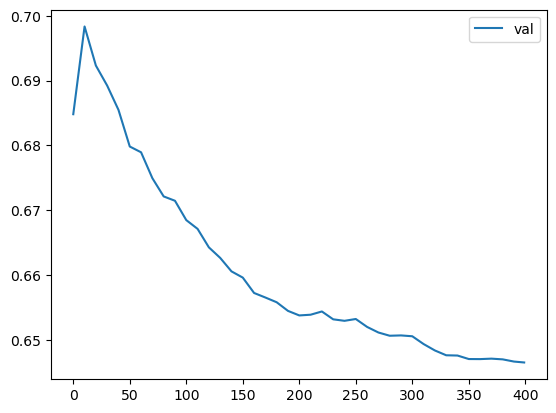

In [35]:
plt.plot(df_score.num_iter, df_score.val_auc, label='val')
plt.legend()

Choosing the best ETA

In [36]:
#Saving dataframes generated at different eta as a dictionary to compare performance
scores={}
scores

{}

For eta = (0.01, 0.05, 0.1, 0.3, 1.0):

In [48]:
%%capture output

xgb_params={'eta':1.0, 
            'max_depth':6, 
            'min_child_weight':1, 
            'objective':'binary:logistic',
            'eval_metric':'auc',
            'nthread': 8, 
            'seed': 1, 
            'verbosity': 1}
watchlist=[(dtrain, 'train'), (dval, 'val')]

xgb_model=xgb.train(xgb_params, dtrain, num_boost_round=400, verbose_eval=10, evals=watchlist)

In [49]:
key='eta=%s' % (xgb_params['eta'])
scores[key]= parse_xgb_output(output)
key

'eta=1.0'

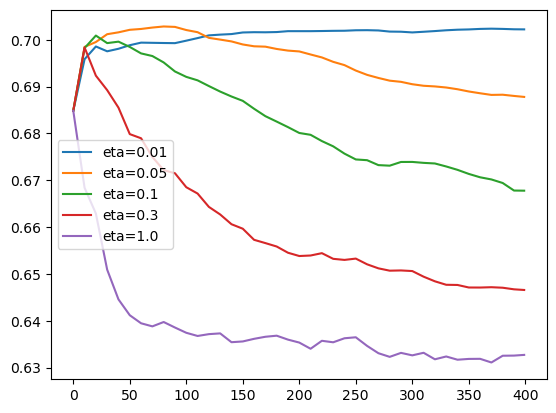

In [50]:
etas = ['eta=0.01', 'eta=0.05', 'eta=0.1', 'eta=0.3', 'eta=1.0']

for e in etas:
    df_score=scores[e]
    plt.plot(df_score.num_iter, df_score.val_auc, label=e)
    plt.legend()

eta=0.01 as the best value

In [51]:
max_eta=0.01

Choosing the best max depth 

In [61]:
%%capture output

xgb_params={'eta':max_eta, 
            'max_depth':10, 
            'min_child_weight':1, 
            'objective':'binary:logistic',
            'eval_metric':'auc',
            'nthread': 8, 
            'seed': 1, 
            'verbosity': 1}
watchlist=[(dtrain, 'train'), (dval, 'val')]

xgb_model=xgb.train(xgb_params, dtrain, num_boost_round=400, verbose_eval=10, evals=watchlist)

In [62]:
key='max_depth=%s' % (xgb_params['max_depth'])
scores[key]= parse_xgb_output(output)
key

'max_depth=10'

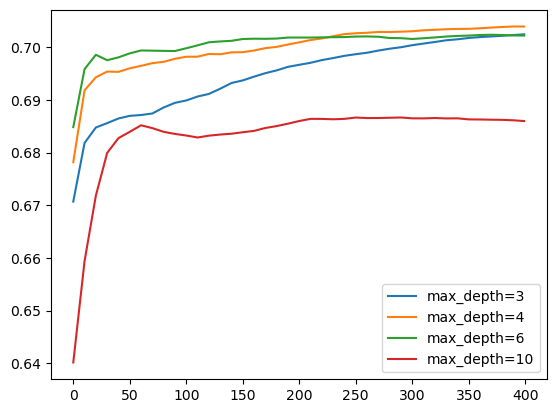

In [63]:
max_d_list = ['max_depth=3', 'max_depth=4', 'max_depth=6', 'max_depth=10']

for md in max_d_list:
    df_score=scores[md]
    plt.plot(df_score.num_iter, df_score.val_auc, label=md)

plt.legend()

In [64]:
max_d=6

Choosing min child weight

In [69]:
%%capture output

xgb_params={'eta':max_eta, 
            'max_depth':max_d, 
            'min_child_weight':30,
            
            'objective':'binary:logistic',
            'eval_metric':'auc',
            
            'nthread': 8, 
            'seed': 1, 
            'verbosity': 1}
watchlist=[(dtrain, 'train'), (dval, 'val')]

xgb_model=xgb.train(xgb_params, dtrain, num_boost_round=400, verbose_eval=10, evals=watchlist)

In [70]:
key='min_child_weight=%s' % (xgb_params['min_child_weight'])
scores[key]= parse_xgb_output(output)
key

'min_child_weight=30'

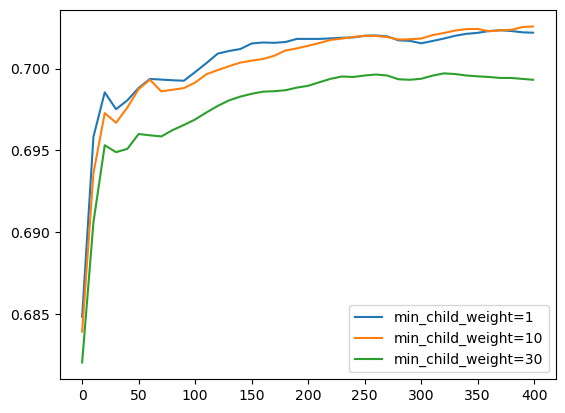

In [71]:
min_cw_list = ['min_child_weight=1', 'min_child_weight=10', 'min_child_weight=30']

for mcw in min_cw_list:
    df_score=scores[mcw]
    plt.plot(df_score.num_iter, df_score.val_auc, label=mcw)

plt.legend()

In [72]:
max_mcw=10

In [73]:
%%capture output
xgb_params={'eta':max_eta, 
            'max_depth':max_d, 
            'min_child_weight':max_mcw,
            
            'objective':'binary:logistic',
            'eval_metric':'auc',
            
            'nthread': 8, 
            'seed': 1, 
            'verbosity': 1}
watchlist=[(dtrain, 'train'), (dval, 'val')]

xgb_model=xgb.train(xgb_params, dtrain, num_boost_round=500, verbose_eval=10, evals=watchlist)

In [74]:
y_pred=xgb_model.predict(dval)
roc_auc_score(y_val, y_pred)

0.7028378775974

# Comparing all models

In [75]:
df1_fulltrain

,engine_rpm,lub_oil_pressure,fuel_pressure,coolant_pressure,lub_oil_temp,coolant_temp,engine_condition
0,590,2.524034,5.790261,2.784885,74.776626,84.214840,1
1,739,2.698556,3.658926,1.565044,74.579922,69.572337,0
2,831,3.120186,5.257630,1.273368,83.949331,70.138496,1
3,614,2.086896,14.022182,1.249490,82.289100,75.204284,1
4,577,2.500811,4.454771,2.358045,76.009929,68.666072,1
...,...,...,...,...,...,...,...
15623,634,4.000401,7.849500,1.779078,75.122539,77.906376,1
15624,669,4.915633,6.368597,1.301831,74.252755,76.590100,0
15625,799,2.299057,7.707614,2.338812,78.069300,82.543909,0
15626,679,3.617365,5.289237,2.077743,75.660330,67.789691,1


In [76]:
X_fulltrain, y_fulltrain, X_test, y_test = dv_train_val_data(df1_fulltrain, df1_test)

Decision Tree

In [77]:
#Decision tree
dt=DecisionTreeClassifier(max_depth=dt_max_d, min_samples_leaf=dt_msl)
dt.fit(X_fulltrain, y_fulltrain)

y_pred_dt=dt.predict_proba(X_test)[:, 1]
roc_auc_score(y_test, y_pred_dt)

0.680338303146584

Random Forest

In [78]:
#Best Random Forest Model
rf=RandomForestClassifier(n_estimators=max_n, max_depth=max_d, min_samples_leaf=max_sl, random_state=1, n_jobs=-1)
rf.fit(X_fulltrain, y_fulltrain)
y_pred_rf=rf.predict_proba(X_test)[:, 1]
roc_auc_score(y_test, y_pred_rf)

0.6975092127171005

XGBoost

In [89]:
#XGBoost
from sklearn.feature_extraction import DictVectorizer

dv=DictVectorizer(sparse=False)
fulltrain_dicts=df1_fulltrain[ss].to_dict(orient='records')
test_dicts=df1_test[ss].to_dict(orient='records')
dv.fit(fulltrain_dicts)

#Preparing Training Data
X_full_train= dv.transform(fulltrain_dicts)
y_full_train=df1_fulltrain.engine_condition.values

#Preparing Validation Data
X_test_xg= dv.transform(test_dicts)
y_test_xg=df1_test.engine_condition.values

dfulltrain=xgb.DMatrix(X_full_train, label=y_full_train, feature_names=ss)
dtest=xgb.DMatrix(X_test_xg, label=y_test_xg, feature_names=ss)

In [87]:
%%capture output
xgb_params={'eta':max_eta, 
            'max_depth':max_d, 
            'min_child_weight':max_mcw,
            
            'objective':'binary:logistic',
            'eval_metric':'auc',
            
            'nthread': 8, 
            'seed': 1, 
            'verbosity': 1}
watchlist=[(dfulltrain, 'train'), (dtest, 'test')]

xgb_model=xgb.train(xgb_params, dfulltrain, num_boost_round=500, verbose_eval=10, evals=watchlist)

In [88]:
y_pred_xgb=xgb_model.predict(dtest)
roc_auc_score(y_test_xg, y_pred_xgb)

0.6972262647829022